# plotting design

In [2]:
import matplotlib.pyplot as plt
import csv
import math
import numpy as np

In [3]:
def xy(ethetas):
    thetas = np.cumsum(ethetas)
    xs = np.arange(0,len(ethetas))
    ys = np.repeat(-1.0,len(ethetas))
    ys[0] = 0
    tans = np.tan(thetas*np.pi/180)
    for i in range(1,len(ys)):
        updt = ys[i-1] + tans[i]
        ys[i] = updt

    return xs,ys

In [5]:
# effective thetas
def thetas(x, y):
    theta = np.repeat(-1.0,len(x))
    theta[0] = 0.0
    for i in range(1,len(x)):
        s = np.sum(theta[:i])
        theta[i] = math.atan((y[i] - y[i-1]) / (x[i] - x[i-1]) ) * 180/math.pi
        theta[i] = theta[i] - s

    if np.any(np.array(theta) < 0):
        raise Exception("Negative angles.")
    return theta

In [6]:
def plot_inlet(angles,flip=True):
    xs,ys = xy(angles)
    fig = plt.figure()
    ax = fig.add_subplot()
    ys = np.max(ys)-ys
    for i in range(len(xs)):
        ax.plot(xs[i:(i+2)],ys[i:(i+2)]);

    ax.hlines(np.max(ys),0,np.max(xs)*1.25)
    ax.hlines(np.min(ys),np.max(xs),np.max(xs)*1.25)
    ax.hlines(np.min(ys),np.max(xs),np.max(xs)*1.25)
    ax.hlines(-0.1*(np.max(ys)-np.min(ys)),0.9*np.max(xs),np.max(xs)*1.25)

    ax.set_aspect('equal', adjustable='box')
    return fig, ax

In [7]:
et = np.array([0,5,5,5])

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

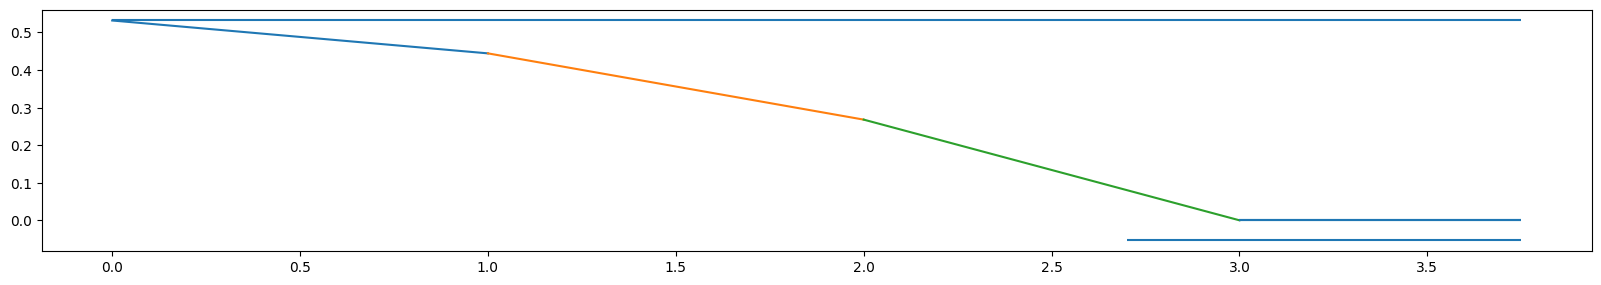

In [8]:
plt.rcParams["figure.figsize"] = (20,10)
plot_inlet(et)

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

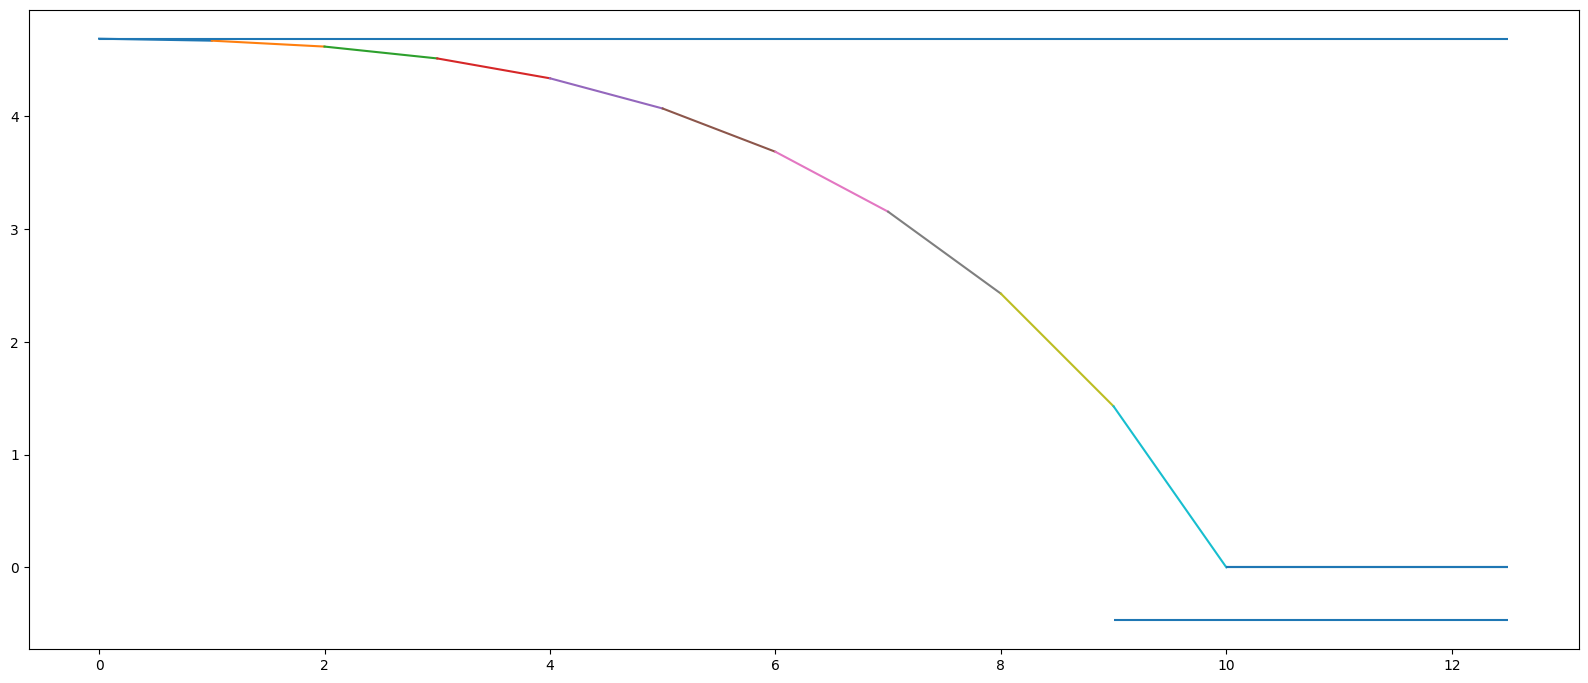

In [9]:
et = np.array([0,1,2,3,4,5,6,7,8,9,10])
plt.rcParams["figure.figsize"] = (20,10)
plot_inlet(et)

## helper functions

In [10]:
import pandas as pd
from itertools import product
import numpy as np

In [11]:
from scipy.optimize import minimize_scalar

In [12]:
#Prandtl-Meyer
def nu(M, gamma):
    return math.sqrt((gamma + 1) / (gamma - 1)) * math.atan(
        math.sqrt((gamma - 1) / (gamma + 1) * (M ** 2 - 1))) - math.atan(math.sqrt(M ** 2 - 1))

In [13]:
def expansion_mach(M1,theta,gamma):
    A = theta*math.pi/180+nu(M1,gamma)
    loss = lambda M2: (nu(M2,gamma)-A)**2
    res = minimize_scalar(loss, bounds=(1, 10), method='bounded')
    return(res.x)

def expansion_p(p1,M1,M2,gamma):
    top = 1+(gamma-1)/2*M1**2
    bottom = 1+(gamma-1)/2*M2**2
    r = (top/bottom)**(gamma/(gamma-1))
    return p1*r

In [14]:
def compression_beta(theta, mach, gamma):
    n = 0 # 0 = weak shock, 1 = strong shock
    theta = theta * math.pi/180.0;
    mu = math.asin(1/mach);
    c = math.tan(mu)**2;
    a = ((gamma-1)/2 + (gamma+1) * c/2) * math.tan(theta);
    b = ((gamma+1)/2 + (gamma+3) * c/2) * math.tan(theta);
    d = math.sqrt(4*(1-3*a*b)**3/((27*a**2*c+9*a*b-2)**2)-1);
    beta = math.atan((b+9*a*c)/(2*(1-3*a*b))-(d*(27*a**2*c+9*a*b-2))/(6*a*(1-3*a*b))*math.tan(n*math.pi/3+1/3*math.atan(1/d)))*180.0/math.pi
    return beta

def compression_mach(mach1, theta, beta, gamma):
    theta = theta * math.pi/180.0;
    beta = beta * math.pi/180.0;
    mach2 = (1/math.sin(beta - theta)) * math.sqrt((1 + 0.5*(gamma-1)*mach1**2*math.sin(beta)**2)/(gamma*mach1**2*math.sin(beta)**2 - 0.5*(gamma-1)))
    return mach2

def p_to_p_tot(p, mach, gamma):
    p_tot = p / ((1 + 0.5*(gamma-1)*mach**2)**(-1*gamma / (gamma-1)))
    return p_tot

def compression_p(mach1, p1, beta, gamma):
    beta = beta * math.pi/180.0
    p2 = p1*((2*gamma*mach1**2*math.sin(beta)**2 - (gamma-1)) / (gamma+1))
    return p2

# run the model

In [15]:
def run_model(mach_inf,p_inf,angles,aoa=0,gamma=1.4,verbose=False):

    x,y = xy(angles)

    mach = []
    beta = []
    p = []
    p_tot = []

    # Initialize Region 0
    mach.append(mach_inf)
    beta.append(0)
    p.append(p_inf)
    p_tot.append(p_to_p_tot(p[0], mach[0], gamma))

    theta = thetas(x, y)
    effective_theta = theta#[theta[0], theta[1]+aoa, theta[2], theta[3], theta[4], theta[5]]
    effective_theta[1] = effective_theta[1] + aoa
    if np.sum(effective_theta[:-1])>=90:
        raise Exception("Sum of effective angles is bigger than 90.")


    # Solve for Regions 1 through 5
    for i in range(1, len(theta)):
        beta.append(compression_beta(effective_theta[i], mach[i-1], gamma))
        mach.append(compression_mach(mach[i-1], effective_theta[i], beta[i], gamma))
        p.append(compression_p(mach[i-1], p[i-1], beta[i], gamma))
        p_tot.append(p_to_p_tot(p[i], mach[i], gamma))

    if verbose:
        print(mach)
        print(beta)
        print(p)
        print(p_tot)

    mach_output = mach[len(mach)-1]
    p_tot_output = p_tot[len(p_tot)-1]
    p_tot_inf = p_inf/((1+mach_inf**2*(gamma-1)/2)**(-gamma/(gamma-1)))

    return {'mach':mach_output, 'pr':p_tot_output/p_tot_inf}


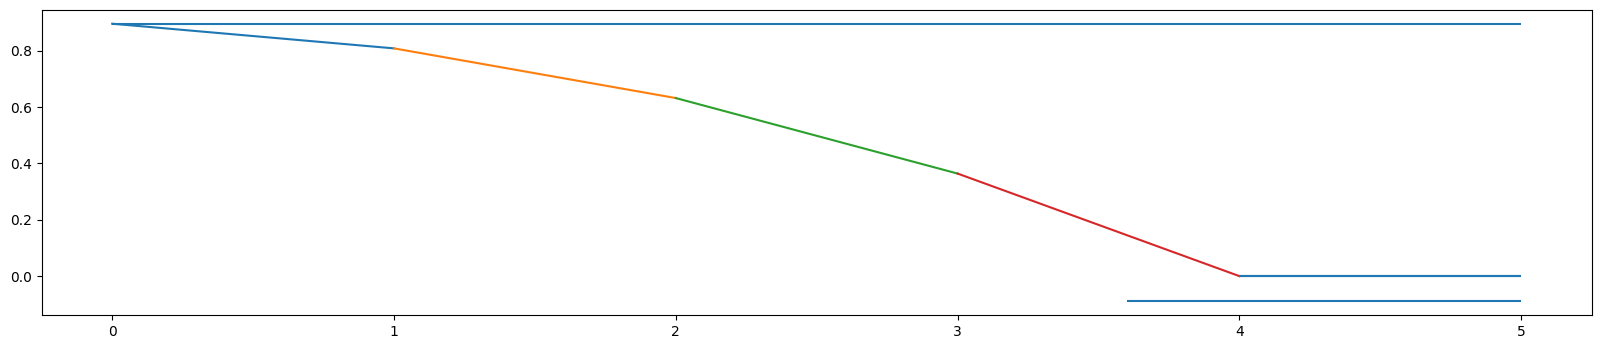

In [16]:
et = np.array([0,5,5,5,5])
plot_inlet(et);

In [17]:
run_model(mach_inf=5,p_inf=5532,angles=et)

{'mach': 3.369974740527841, 'pr': 0.9440513806000923}

{'mach': 1.7886493208491026, 'pr': 0.891436731569959}

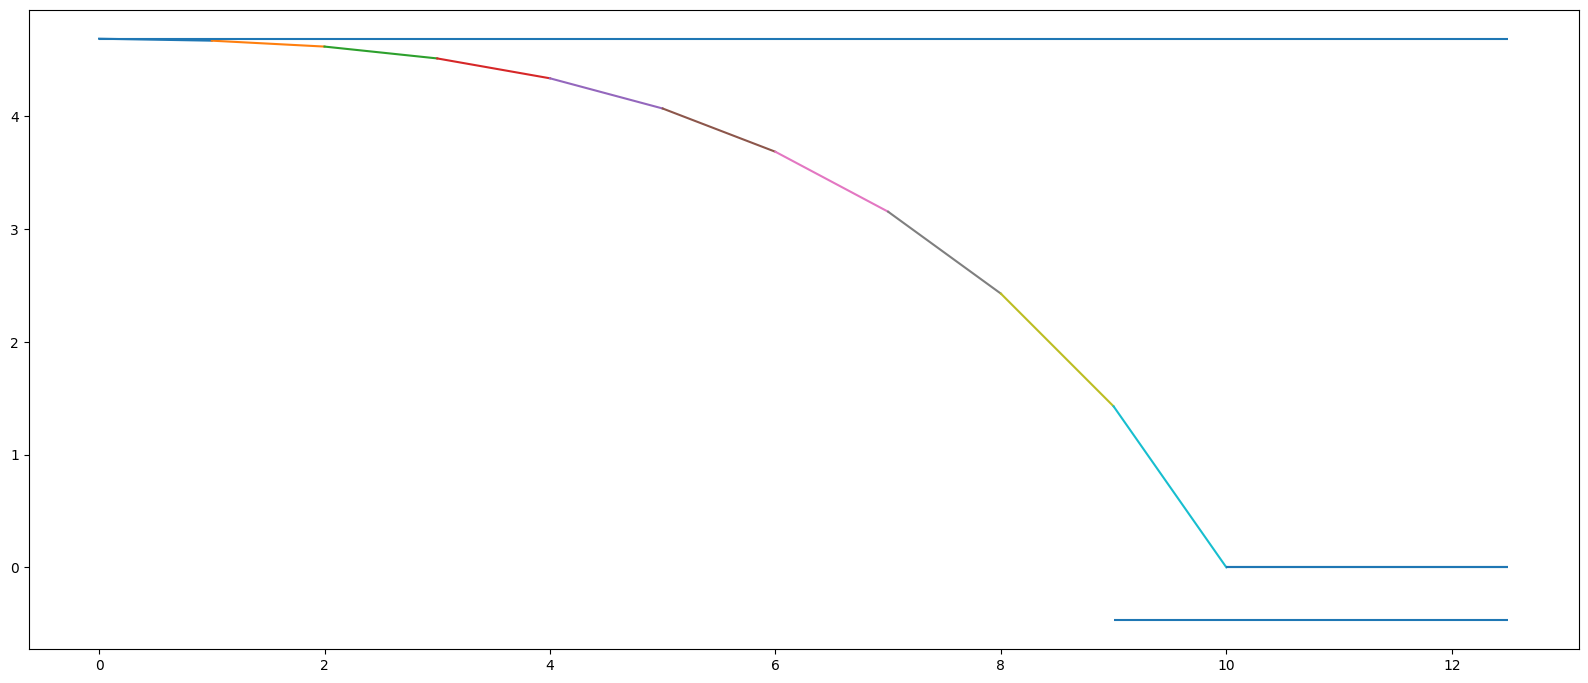

In [18]:
et = np.array([0,1,2,3,4,5,6,7,8,9,10])
plot_inlet(et);
run_model(mach_inf=5,p_inf=5532,angles=et)

### **Mach Number for Even Angles**

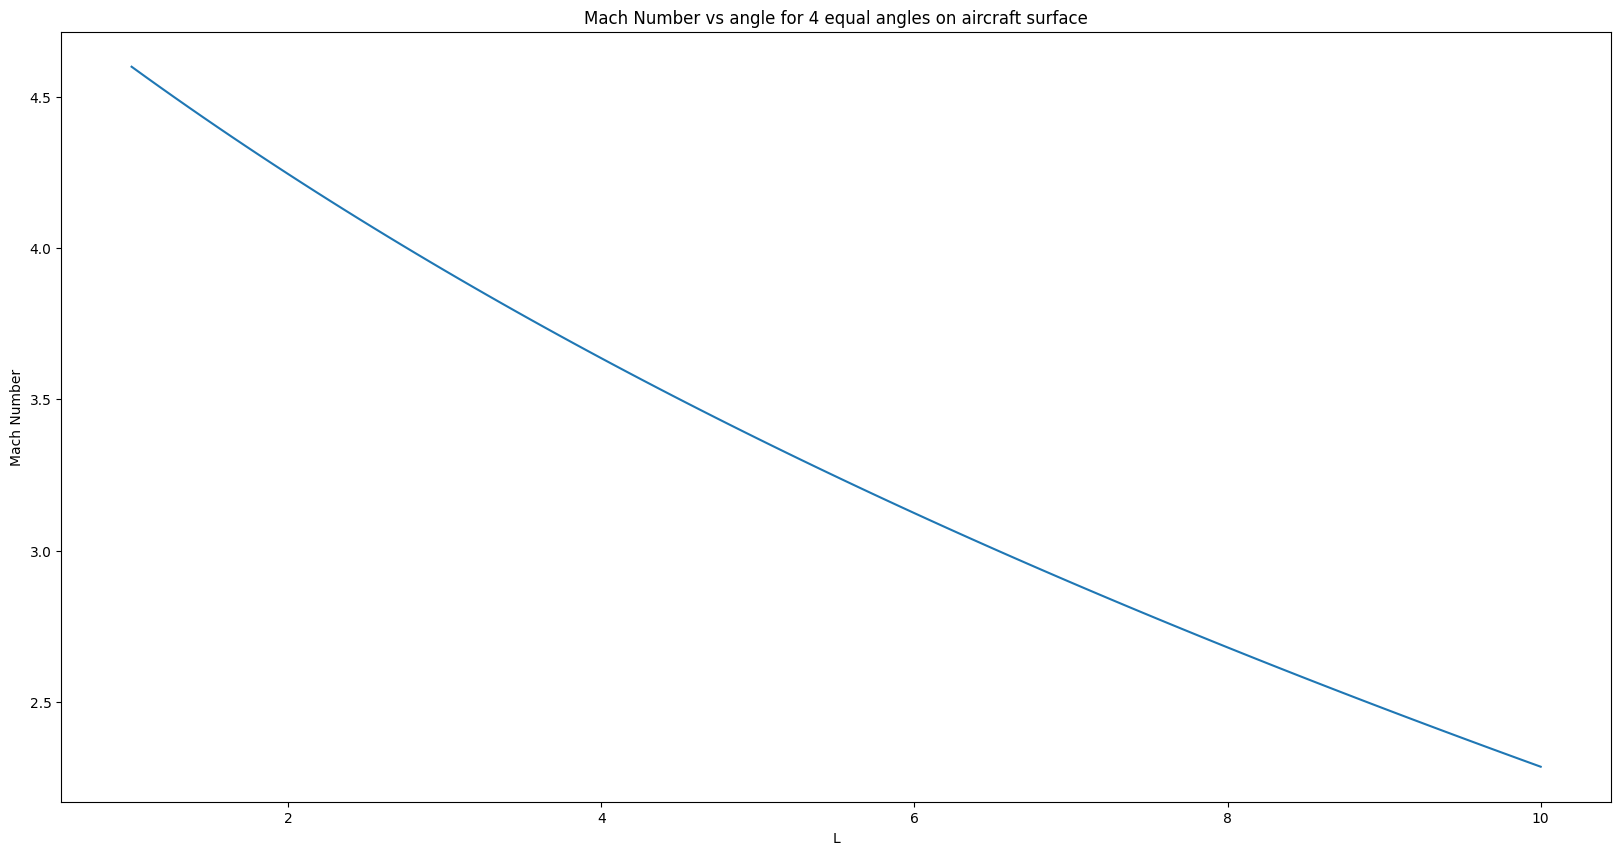

In [28]:
L = np.linspace(1,10,100)
def nparrayf(A):
    B = int(A)
    return np.array([0,B,B,B,B])

mach_numbers = []
for x in L:
    et = np.array([0, x, x, x, x])
    result = run_model(mach_inf=5, p_inf=5532, angles=et)
    mach_numbers.append(result['mach'])

mach_numbers = np.array(mach_numbers)

plt.figure()
plt.plot(L, mach_numbers, label='Mach Number')
plt.xlabel('L')
plt.ylabel('Mach Number')
plt.title('Mach Number vs angle for 4 equal angles on aircraft surface')
plt.show()

### **Mach Number for 2 Different Angles**

In [39]:
import plotly.graph_objects as go
import itertools

In [89]:
L = np.linspace(1,10,10)
mach_numbers = []
mach_matrix = []
for i in L:
  row = []
  for j in L:
    et = np.array([0,i,j,i,j])
    result = run_model(mach_inf=5, p_inf=5532, angles=et)
    row.append(result['mach'])
  mach_matrix.append(row)

#for index, row in enumerate(mach_matrix):
    #print(f"List {index + 1}: {row}")

fig = go.Figure(data=go.Heatmap(
                   z=[mach_matrix[0], mach_matrix[1], mach_matrix[2], mach_matrix[3], mach_matrix[4], mach_matrix[5], mach_matrix[6], mach_matrix[7], mach_matrix[8], mach_matrix[9]],
                   x=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                   y=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                   hoverongaps = False))
fig.show()

### **Pressure for 2 Different Angles**

In [88]:
L = np.linspace(1,10,10)
pr_numbers = []
pr_matrix = []
for i in L:
  row = []
  for j in L:
    et = np.array([0,i,j,i,j])
    result = run_model(mach_inf=5, p_inf=5532, angles=et)
    row.append(result['pr'])
  pr_matrix.append(row)

#for index, row in enumerate(mach_matrix):
    #print(f"List {index + 1}: {row}")

fig = go.Figure(data=go.Heatmap(
                   z=[pr_matrix[0], pr_matrix[1], pr_matrix[2], pr_matrix[3], pr_matrix[4], pr_matrix[5], pr_matrix[6], pr_matrix[7], pr_matrix[8], pr_matrix[9]],
                   x=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                   y=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                   hoverongaps = False))
fig.show()